<a href="https://colab.research.google.com/github/GrzegorzMeller/AlgorithmsForMassiveData/blob/master/OCULAR_DISEASE_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip ocular-disease-recognition-odir5k.zip
!mkdir ODIR-5K/Validation_Images

In [34]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

training_images_file = 'ODIR-5K/Training Images'
testing_images_file = 'ODIR-5K/Testing Images'
labels_file = 'ODIR-5K/data.xlsx'

diseases = {'abnormal pigment ': 'O', 'age-related macular degeneration': 'A', 'anterior segment image': 'DELETE', 'arteriosclerosis': 'NaN', 'asteroid hyalosis': 'O', 'atrophic change': 'O', 'atrophy': 'O', 'branch retinal artery occlusion': 'O', 'branch retinal vein occlusion': 'O', 'cataract': 'C', 'central retinal artery occlusion': 'O', 'central retinal vein occlusion': 'O', 'central serous chorioretinopathy': 'O', 'chorioretinal atrophy': 'O', 'chorioretinal atrophy with pigmentation proliferation': 'O', 'choroidal nevus': 'NaN', 'congenital choroidal coloboma': 'O', 'depigmentation of the retinal pigment epithelium': 'O', 'diabetic retinopathy': 'D', 'diffuse chorioretinal atrophy': 'O', 'diffuse retinal atrophy': 'O', 'drusen': 'O', 'dry age-related macular degeneration': 'A', 'epiretinal membrane': 'O', 'epiretinal membrane over the macula': 'O', 'fundus laser photocoagulation spots': 'O', 'glaucoma': 'G', 'glial remnants anterior to the optic disc': 'O', 'hypertensive retinopathy': 'H', 'hypertensive retinopathy,diabetic retinopathy': 'D', 'idiopathic choroidal neovascularization': 'O', 'image offset': 'DELETE', 'intraretinal hemorrhage': 'O', 'intraretinal microvascular abnormality': 'O', 'laser spot': 'O', 'lens dust': 'DELETE', 'low image quality': 'DELETE', 'low image quality,maculopathy': 'DELETE', 'macular coloboma': 'O', 'macular epiretinal membrane': 'O', 'macular hole': 'O', 'macular pigmentation disorder': 'NaN', 'maculopathy': 'O', 'mild nonproliferative retinopathy': 'D', 'moderate non proliferative retinopathy': 'D', 'morning glory syndrome': 'O', 'myelinated nerve fibers': 'O', 'myopia retinopathy': 'M', 'myopic maculopathy': 'M', 'myopic retinopathy': 'M', 'no fundus image': 'DELETE', 'normal fundus': 'N', 'old branch retinal vein occlusion': 'O', 'old central retinal vein occlusion': 'O', 'old chorioretinopathy': 'O', 'old choroiditis': 'NaN', 'optic disc edema': 'O', 'optic discitis': 'O', 'optic disk epiretinal membrane': 'O', 'optic disk photographically invisible': 'DELETE', 'optic nerve atrophy': 'O', 'oval yellow-white atrophy': 'O', 'pathological myopia': 'M', 'peripapillary atrophy': 'O', 'pigment epithelium proliferation': 'O', 'pigmentation disorder': 'O', 'post laser photocoagulation': 'O', 'post retinal laser surgery': 'O', 'proliferative diabetic retinopathy': 'D', 'punctate inner choroidopathy': 'O', 'refractive media opacity': 'O', 'retina fold': 'O', 'retinal artery macroaneurysm': 'O', 'retinal detachment': 'O', 'retinal pigment epithelial hypertrophy': 'O', 'retinal pigment epithelium atrophy': 'O', 'retinal pigmentation': 'O', 'retinal vascular sheathing': 'O', 'retinitis pigmentosa': 'O', 'retinochoroidal coloboma': 'O', 'rhegmatogenous retinal detachment': 'O', 'severe nonproliferative retinopathy': 'D', 'severe proliferative diabetic retinopathy': 'D', 'silicone oil eye': 'O', 'spotted membranous change': 'O', 'suspected abnormal color of  optic disc': 'O', 'suspected cataract': 'C', 'suspected diabetic retinopathy': 'D', 'suspected glaucoma': 'G', 'suspected macular epimacular membrane': 'O', 'suspected microvascular anomalies': 'O', 'suspected moderate non proliferative retinopathy': 'D', 'suspected retinal vascular sheathing': 'O', 'suspected retinitis pigmentosa': 'O', 'suspicious diabetic retinopathy': 'D', 'tessellated fundus': 'O', 'vascular loops': 'O', 'vessel tortuosity': 'O', 'vitreous degeneration': 'O', 'vitreous opacity': 'O', 'wedge white line change': 'O', 'wedge-shaped change': 'O', 'wet age-related macular degeneration': 'A', 'white vessel': 'O'}

#load labels to pandas
labels = pd.read_excel(labels_file, index_col=0) 
print(labels['Left-Diagnostic Keywords'][0])
print(diseases)

cataract
{'abnormal pigment ': 'O', 'age-related macular degeneration': 'A', 'anterior segment image': 'DELETE', 'arteriosclerosis': 'NaN', 'asteroid hyalosis': 'O', 'atrophic change': 'O', 'atrophy': 'O', 'branch retinal artery occlusion': 'O', 'branch retinal vein occlusion': 'O', 'cataract': 'C', 'central retinal artery occlusion': 'O', 'central retinal vein occlusion': 'O', 'central serous chorioretinopathy': 'O', 'chorioretinal atrophy': 'O', 'chorioretinal atrophy with pigmentation proliferation': 'O', 'choroidal nevus': 'NaN', 'congenital choroidal coloboma': 'O', 'depigmentation of the retinal pigment epithelium': 'O', 'diabetic retinopathy': 'D', 'diffuse chorioretinal atrophy': 'O', 'diffuse retinal atrophy': 'O', 'drusen': 'O', 'dry age-related macular degeneration': 'A', 'epiretinal membrane': 'O', 'epiretinal membrane over the macula': 'O', 'fundus laser photocoagulation spots': 'O', 'glaucoma': 'G', 'glial remnants anterior to the optic disc': 'O', 'hypertensive retinopat

In [0]:
def update_filenames(file_path):
  all_paths = []
  for element in glob.glob(file_path+"/*.jpg"):
    all_paths.append(element)
  paths = []

  for u_id in labels.index:
    labelL = ""
    labelR = ""
    diagnosticL = labels['Left-Diagnostic Keywords'][u_id]
    diagnosticR = labels['Right-Diagnostic Keywords'][u_id]
    diagnosticL = diagnosticL.split("，") 
    diagnosticR = diagnosticR.split("，") 
    #print(diagnosticL)
    for d in diagnosticL:
      if d in diseases:
          if labelL != "":
            labelL+="&"+diseases[d]
          else:
            labelL+=diseases[d]
      else:
          labelL+="DELETE"
    for d in diagnosticR:
      if d in diseases:
        if labelR != "":
          labelR+="&"+diseases[d]
        else:
          labelR+=diseases[d]
      else:
        labelR+="DELETE"

    if file_path+"/"+str(labels['Left-Fundus'][u_id]) in all_paths:
      filename = str(labels['Left-Fundus'][u_id]).split(".")
      os.rename(file_path+"/"+str(labels['Left-Fundus'][u_id]), file_path+"/"+filename[0]+"-"+labelL+".jpg")
      paths.append(file_path+"/"+str(labels['Left-Fundus'][u_id])+"/"+labelL)
  
    if file_path+"/"+str(labels['Right-Fundus'][u_id]) in all_paths:
      filename = str(labels['Right-Fundus'][u_id]).split(".")
      os.rename(file_path+"/"+str(labels['Right-Fundus'][u_id]), file_path+"/"+filename[0]+"-"+labelR+".jpg")
      paths.append(file_path+"/"+str(labels['Right-Fundus'][u_id])+"/"+labelR)
      
update_filenames(training_images_file)

In [12]:
def show_class_distribution():
  N = 0
  D=0
  G=0
  C=0
  A=0
  H=0
  M=0
  O = 0
  MIX = 0
  DELETE = 0
  items_to_remove = []
  for element in glob.glob("ODIR-5K/Training Images/*.jpg"):
    img_name = element.split("/")[-1]
    img_label = img_name.split("-")
    if img_label[-1] == "N.jpg":
      N += 1
    elif img_label[-1] == "D.jpg":
      D +=1
    elif img_label[-1] == "G.jpg":
      G +=1
    elif img_label[-1] == "C.jpg":
      C +=1
    elif img_label[-1] == "A.jpg":
      A +=1
    elif img_label[-1] == "H.jpg":
      H +=1
    elif img_label[-1] == "M.jpg":
      M +=1
    elif img_label[-1] == "O.jpg":
      O +=1
    elif "DELETE" in img_label[-1]:
      DELETE+=1
      items_to_remove.append(element)
    elif "&" in img_label[-1]:
      MIX +=1
      items_to_remove.append(element)

  for e in items_to_remove:
    os.remove(e)
    
  print(N, D, G, C, A, H, M, O, DELETE, MIX)
  print(N+D+G+C+A+H+M+O)
  return N, D, G, C, A, H, M, O, DELETE, MIX
      
show_class_distribution()

2816 1386 218 262 237 104 237 756 436 548
6016


(2816, 1386, 218, 262, 237, 104, 237, 756, 436, 548)

In [13]:
#move randomly selected 1000 files to Validation Images directory
all_paths = []
for element in glob.glob("ODIR-5K/Training Images/*.jpg"):
  all_paths.append(element)
num_to_select = 800                          
list_of_random_items = random.sample(all_paths, num_to_select)
for element in list_of_random_items:
  p = element.split("/")
  os.replace(element, "ODIR-5K/Validation_Images/"+p[-1])

show_class_distribution()

2442 1210 185 236 202 92 206 643 0 0
5216


(2442, 1210, 185, 236, 202, 92, 206, 643, 0, 0)

In [44]:
train_N_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*N.jpg").repeat()
train_D_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*D.jpg").repeat()
train_G_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*G.jpg").repeat()
train_C_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*C.jpg").repeat()
train_A_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*A.jpg").repeat()
train_H_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*H.jpg").repeat()
train_M_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*M.jpg").repeat()
train_O_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*O.jpg").repeat()
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

for f in train_G_ds.take(5):
  print(f.numpy())

for f in test_ds.take(5):
  print(f.numpy())

b'ODIR-5K/Training Images/167_left-G.jpg'
b'ODIR-5K/Training Images/1272_right-G.jpg'
b'ODIR-5K/Training Images/1393_right-G.jpg'
b'ODIR-5K/Training Images/1963_right-G.jpg'
b'ODIR-5K/Training Images/1397_left-G.jpg'
b'ODIR-5K/Validation_Images/384_right-O.jpg'
b'ODIR-5K/Validation_Images/2831_left-N.jpg'
b'ODIR-5K/Validation_Images/794_right-D.jpg'
b'ODIR-5K/Validation_Images/599_right-O.jpg'
b'ODIR-5K/Validation_Images/2490_right-N.jpg'


In [0]:
resampled1_ds = tf.data.experimental.sample_from_datasets([train_N_ds, train_D_ds, train_G_ds, train_C_ds, 
                                                          train_A_ds, train_H_ds, train_M_ds, train_O_ds],
                                                         weights=[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

In [46]:
for f in resampled1_ds.take(10):
  print(f.numpy())

b'ODIR-5K/Training Images/179_left-H.jpg'
b'ODIR-5K/Training Images/2247_left-C.jpg'
b'ODIR-5K/Training Images/1469_right-G.jpg'
b'ODIR-5K/Training Images/1989_left-H.jpg'
b'ODIR-5K/Training Images/2115_right-C.jpg'
b'ODIR-5K/Training Images/398_left-O.jpg'
b'ODIR-5K/Training Images/1563_right-M.jpg'
b'ODIR-5K/Training Images/335_left-N.jpg'
b'ODIR-5K/Training Images/266_left-A.jpg'
b'ODIR-5K/Training Images/4174_right-D.jpg'


In [0]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  l = 0
  if label[0] == 'N':
    l = 0
  elif label[0] == 'D':
    l = 1
  elif label[0] == 'G':
    l = 2
  elif label[0] == 'C':
    l = 3
  elif label[0] == 'A':
    l = 4
  elif label[0] == 'H':
    l = 5
  elif label[0] == 'M':
    l = 6
  else:
    l = 7
  return l #== CLASS_NAMES

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.adjust_contrast(img, 3)
  #img = tf.image.rgb_to_grayscale(img)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  #img = tf.reshape(image, IMG_HEIGHT*IMG_WIDTH)
  return img

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
resampled_named_ds = resampled1_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

(32, 32, 3)
label:  5
(32, 32, 3)
label:  3
(32, 32, 3)
label:  2
(32, 32, 3)
label:  5


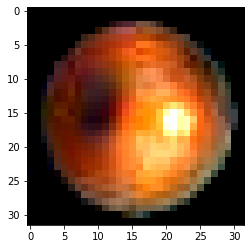

In [49]:
for image, label in resampled_named_ds.take(4):
  print(image.shape)
  plt.imshow(image.numpy())
  print('label: ', label.numpy())

In [50]:
pom = []
for image, labels in resampled_named_ds.take(9000):
  pom.append(labels.numpy())
uni = np.unique(pom)
for element in uni:
  print(str(element)+" : "+str(pom.count(element)))

0 : 1110
1 : 1134
2 : 1119
3 : 1118
4 : 1133
5 : 1102
6 : 1107
7 : 1177


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.cache()
  ds = ds.batch(32, drop_remainder=True) #all elemetnts for training should be batched in one!
  ds = ds.repeat()

  return ds

In [0]:
final_train_ds = prepare_for_training(resampled_named_ds,cache=True,shuffle_buffer_size=6000)
final_test_ds = prepare_for_testing(test_named_ds,cache=True,shuffle_buffer_size=100)

1
tf.Tensor(4, shape=(), dtype=int32)


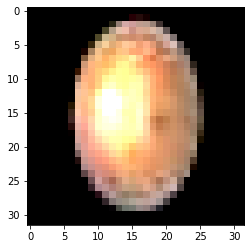

In [53]:
i=0
for example in final_train_ds.take(1):
  image, label = example
  i+=1
  print(i)
  break
im, lab = image[14], label[14]
plt.imshow(im)
print(lab)

In [16]:
next(iter(final_train_ds))

(<tf.Tensor: shape=(32, 1500, 1500, 3), dtype=float32, numpy=
 array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
 

In [54]:
model_cnn = tf.keras.Sequential([
    
    # 1st VGG block
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(32, (3, 3), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),

    #2nd VGG block
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(128, (3, 3), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(8, activation = 'softmax')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        96        
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        96        
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)       

In [55]:
history_cnn = model_cnn.fit(final_train_ds.repeat(),
                    #batch_size=32,
                    epochs=100,
                    steps_per_epoch = 163, #train_elements/batch_size
                    validation_data=final_test_ds.repeat(),
                    validation_steps = 25,
                    use_multiprocessing=True,
                    #class_weight=class_weight
                    )

Epoch 1/100
163/163 [==============================] - 4s 23ms/step - loss: 8.1399 - accuracy: 0.1737 - val_loss: 2.9411 - val_accuracy: 0.0650
Epoch 2/100
163/163 [==============================] - 4s 22ms/step - loss: 3.6585 - accuracy: 0.2239 - val_loss: 2.5364 - val_accuracy: 0.1225
Epoch 3/100
163/163 [==============================] - 4s 23ms/step - loss: 1.8923 - accuracy: 0.3204 - val_loss: 2.0317 - val_accuracy: 0.1587
Epoch 4/100
163/163 [==============================] - 4s 23ms/step - loss: 1.6202 - accuracy: 0.3934 - val_loss: 1.9329 - val_accuracy: 0.2050
Epoch 5/100
163/163 [==============================] - 4s 23ms/step - loss: 1.5352 - accuracy: 0.4195 - val_loss: 2.3579 - val_accuracy: 0.1088
Epoch 6/100
163/163 [==============================] - 3s 21ms/step - loss: 1.4516 - accuracy: 0.4576 - val_loss: 2.0247 - val_accuracy: 0.1737
Epoch 7/100
163/163 [==============================] - 3s 20ms/step - loss: 1.3870 - accuracy: 0.4879 - val_loss: 1.8511 - val_accuracy:

In [0]:
!rm -rf ODIR-5K/Training-Images